In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from IPython.display import display
import matplotlib.patches as patches

In [2]:
# Считываем данные
path = '/kaggle/input/rutube-dataset/' # путь до данных
data = pd.read_csv(path + 'train_events.csv')
data_all = pd.read_csv(path + 'all_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')

In [3]:
# Объединяем события просмотров с информацией о видео
merged = data.merge(targets, on=("viewer_uid")).merge(video, on=("rutube_video_id"))
merged_all = data_all.merge(video, on=("rutube_video_id"))

# t-SNE

Применим t-SNE на данных о категориях видео, которые смотрят пользователи.

In [4]:
def transform(df, cat_values):
    # Создаем пустой DataFrame для хранения результата
    result = pd.DataFrame()

    # Считаем общее количество событий (total) один раз для всех категорий
    total_events_per_user = df.groupby('viewer_uid').size().reset_index(name='total_events')

    # Для каждой категории из cat_values
    for column, top_values in cat_values.items():
        # Для каждой уникальной категории создаем новый столбец
        for value in top_values:
            # Создаем временный столбец, где 1, если категория совпадает, иначе 0
            col_name = f"{column}_{value}"
            df[col_name] = (df[column] == value).astype(int)

            # Агрегируем по viewer_uid и считаем количество совпадений
            agg_result = df.groupby('viewer_uid')[col_name].sum().reset_index()

            # Считаем долю от общего количества событий (total)
            agg_result[col_name] = agg_result[col_name] / total_events_per_user['total_events']

            # Оставляем только нужные столбцы
            agg_result = agg_result[['viewer_uid', col_name]]

            # Объединяем результат с основным DataFrame по viewer_uid
            if result.empty:
                result = agg_result
            else:
                result = result.merge(agg_result, on='viewer_uid', how='outer')

    # Добавляем столбец с total событий (один раз) в итоговый результат
    result = result.merge(total_events_per_user, on='viewer_uid', how='outer')

    return result

In [5]:
# Преобразуем историю просмотров пользователя в вектор
categories_list = merged["category"].value_counts().index.to_list()
transformed = transform(merged, {"category" : categories_list})

In [6]:
# Используем только пользователей, просмотревших больше 5 видео
sample = transformed[transformed["total_events"] > 5].sample(8000, random_state=42)
sample_target = sample.merge(targets, on=("viewer_uid"))
X = sample[sample.columns[1:41]].to_numpy()
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=40.0, n_jobs=4, random_state=42).fit_transform(X)

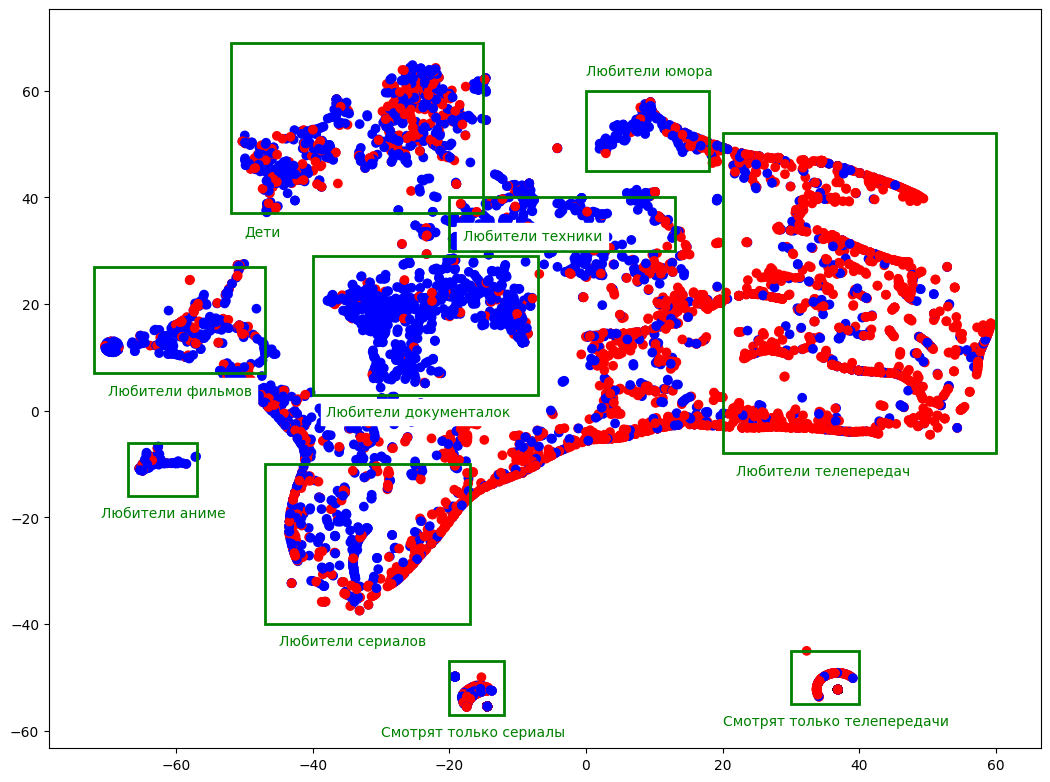

In [7]:
plt.figure(figsize=[6.4 * 2, 4.8 * 2])
color = [("r" if sex == "female" else "b") for sex in sample_target["sex"]]
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=color)

rect = patches.Rectangle((-40, 3), 33, 26, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-40 + 2, 3 - 4, "Любители документалок", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-52, 37), 37, 32, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-52 + 2, 37 - 4, "Дети", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((20, -8), 40, 60, linewidth=2, edgecolor='g', facecolor='none')
plt.text(20 + 2, -8 - 4, "Любители телепередач", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((30, -55), 10, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(30 - 10, -55 - 4, "Смотрят только телепередачи", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-20, -57), 8, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-20 - 10, -57 - 4, "Смотрят только сериалы", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-47, -40), 30, 30, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-47 + 2, -40 - 4, "Любители сериалов", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-72, 7), 25, 20, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-72 + 2, 7 - 4, "Любители фильмов", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-20, 30), 33, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-20 + 2, 30 + 2, "Любители техники", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((0, 45), 18, 15, linewidth=2, edgecolor='g', facecolor='none')
plt.text(0, 63, "Любители юмора", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-67, -16), 10, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-67 - 4, -16 - 4, "Любители аниме", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

plt.show()

Получившиеся группы пользователей были вручную проанализированы и обозначены. Видно, что в некоторых группах пользователей преобладает один из полов.

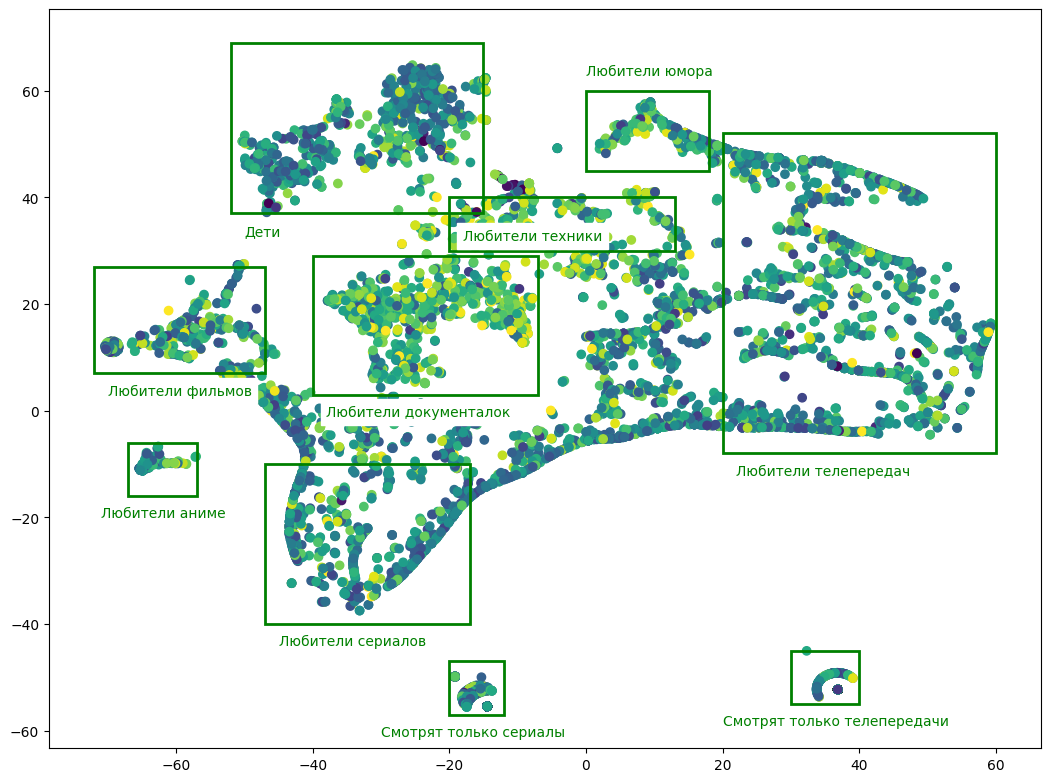

In [8]:
plt.figure(figsize=[6.4 * 2, 4.8 * 2])
color = [(age + 1) / 3 for age in sample_target["age"]]
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=color)

rect = patches.Rectangle((-40, 3), 33, 26, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-40 + 2, 3 - 4, "Любители документалок", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-52, 37), 37, 32, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-52 + 2, 37 - 4, "Дети", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((20, -8), 40, 60, linewidth=2, edgecolor='g', facecolor='none')
plt.text(20 + 2, -8 - 4, "Любители телепередач", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((30, -55), 10, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(30 - 10, -55 - 4, "Смотрят только телепередачи", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-20, -57), 8, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-20 - 10, -57 - 4, "Смотрят только сериалы", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-47, -40), 30, 30, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-47 + 2, -40 - 4, "Любители сериалов", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-72, 7), 25, 20, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-72 + 2, 7 - 4, "Любители фильмов", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-20, 30), 33, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-20 + 2, 30 + 2, "Любители техники", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((0, 45), 18, 15, linewidth=2, edgecolor='g', facecolor='none')
plt.text(0, 63, "Любители юмора", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

rect = patches.Rectangle((-67, -16), 10, 10, linewidth=2, edgecolor='g', facecolor='none')
plt.text(-67 - 4, -16 - 4, "Любители аниме", c="g", backgroundcolor="w")
plt.gca().add_patch(rect)

plt.show()

То же самое, но с обозначением возраста пользователей (чем светлее, тем старше).

In [9]:
merged = data.merge(targets, on=("viewer_uid")).merge(video, on=("rutube_video_id"))

## Продолжительность просмотров и длина видео

Есть выбросы по времени просмотра:

In [10]:
max_watchtime = merged["total_watchtime"].max() / (60 * 60 * 24)
print(f"Максимальная продолжительность просмотра: {max_watchtime:.2f} дней.")

Максимальная продолжительность просмотра: 28.81 дней.


Длина видео, просмотренных известными пользователями:

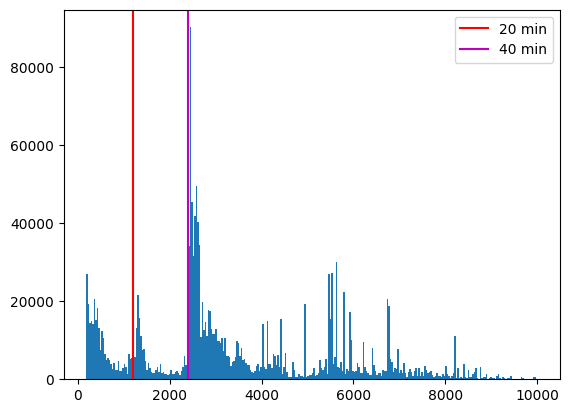

In [11]:
plt.hist(merged["duration"][merged["duration"] / 1000 < 10000] / 1000, bins=300)
plt.axvline(x = 1200, color = 'r', label = '20 min')
plt.axvline(x = 2400, color = 'm', label = '40 min')
plt.legend()
plt.show()

Длина видео, просмотренных неизвестными пользователями:

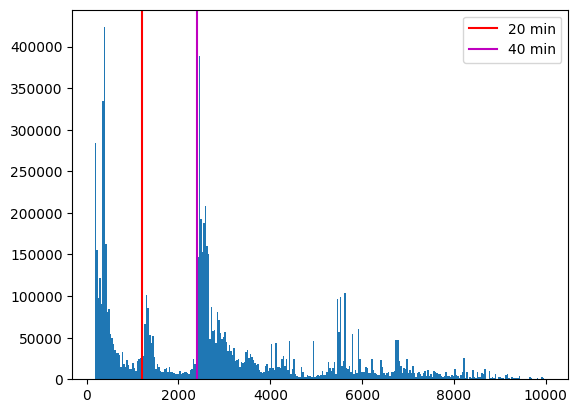

In [12]:
plt.hist(merged_all["duration"][merged_all["duration"] / 1000 < 10000] / 1000, bins=300)
plt.axvline(x = 1200, color = 'r', label = '20 min')
plt.axvline(x = 2400, color = 'm', label = '40 min')
plt.legend()
plt.show()

Продолжительность просмотров известными пользователями:

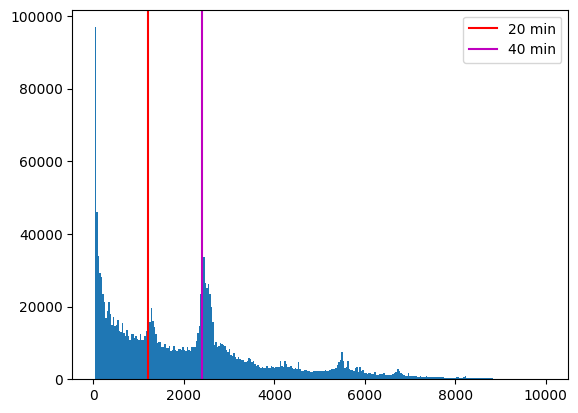

In [13]:
plt.hist(data["total_watchtime"][data["total_watchtime"] < 10000], bins=300)
plt.axvline(x = 1200, color = 'r', label = '20 min')
plt.axvline(x = 2400, color = 'm', label = '40 min')
plt.legend()
plt.show()

Есть большое количество видео (и просмотров) длиной 20 и 40 минут.

# Вспомогательные функции

In [14]:
# Показывает круговую диаграмму по категориальной переменной
def make_pie_chart(column, merged, take=None):
    counts = pd.DataFrame(merged[column].value_counts())
    
    if take is None:
        plt.pie(counts["count"], labels=counts.index, autopct='%1.0f%%', pctdistance=0.9, labeldistance=1.2)
    else:
        counts = counts.iloc[:take]._append(pd.DataFrame({"count" : counts.iloc[take:].sum().iloc[0]}, index=["Остальное"]))
        plt.pie(counts["count"], labels=counts.index, explode=[0 for _ in range(take)] + [0.1], autopct='%1.0f%%', pctdistance=0.9, labeldistance=1.2)
    
    plt.show()

In [15]:
# Показывает столбчатую диаграмму по полам в абсолютных значениях
def make_gender_bars(column, merged, take=None):
    female = merged[merged["sex"] == "female"].groupby(column).count()["sex"]
    male = merged[merged["sex"] == "male"].groupby(column).count()["sex"]
    total = male + female
    total = total.sort_values(ascending=False)
    female = female.reindex(total.index)
    male = male.reindex(total.index)
    
    if take is not None:
        total = total[:take]
        female = female[:take]
        male = male[:take]

    plt.figure(figsize=[6.4 * 2, 4.8 * 2])
    plt.bar(female.index, female, color='r', label="female")
    plt.bar(male.index, male, bottom=female, color='b', label="male")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Показывает столбчатую диаграмму по полам в относительных значениях
def make_gender_bars_relative(column, merged, take=None):
    female = merged[merged["sex"] == "female"].groupby(column).count()["sex"]
    male = merged[merged["sex"] == "male"].groupby(column).count()["sex"]
    total = male + female
    total = total.sort_values(ascending=False)
    female = female.reindex(total.index)
    male = male.reindex(total.index)
    
    if take is not None:
        total = total[:take]
        female = female[:take]
        male = male[:take]
    
    male = male / total
    female = female / total
    male = male.sort_values()
    female = female.reindex(male.index)

    plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
    plt.bar(female.index, female, color='r', label="female")
    plt.bar(male.index, male, bottom=female, color='b', label="male")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [16]:
# Показывает столбчатую диаграмму по смещению возраста относительно категориальной переменной
def make_age_bias(column, merged, take=None):
    mean_age = merged["age"].mean()
    age_bias = merged.groupby(column)["age"].mean() - mean_age
    
    if take is not None:
        index = merged[column].value_counts()[:take].index
        age_bias = age_bias[index]
    
    age_bias = age_bias.sort_values()

    plt.figure(figsize=[6.4 * 1.5, 4.8 * 2])
    colors = ['g' if e >= 0 else 'r' for e in age_bias]
    plt.barh(age_bias.index, age_bias, color=colors)
    plt.xlabel(f"Смещение относительно среднего возраста ({mean_age:.2f} лет)")
    plt.show()

# Категории видео

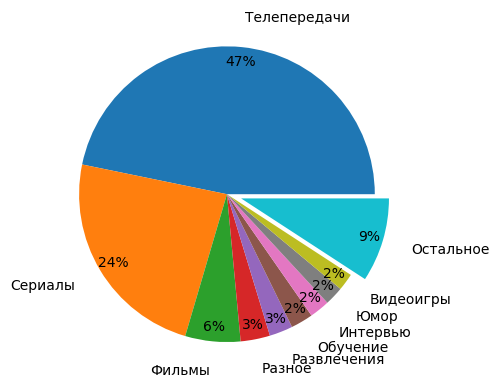

In [17]:
make_pie_chart("category", merged, 9)

Телепередачи составляют почти половину всех просмотров.

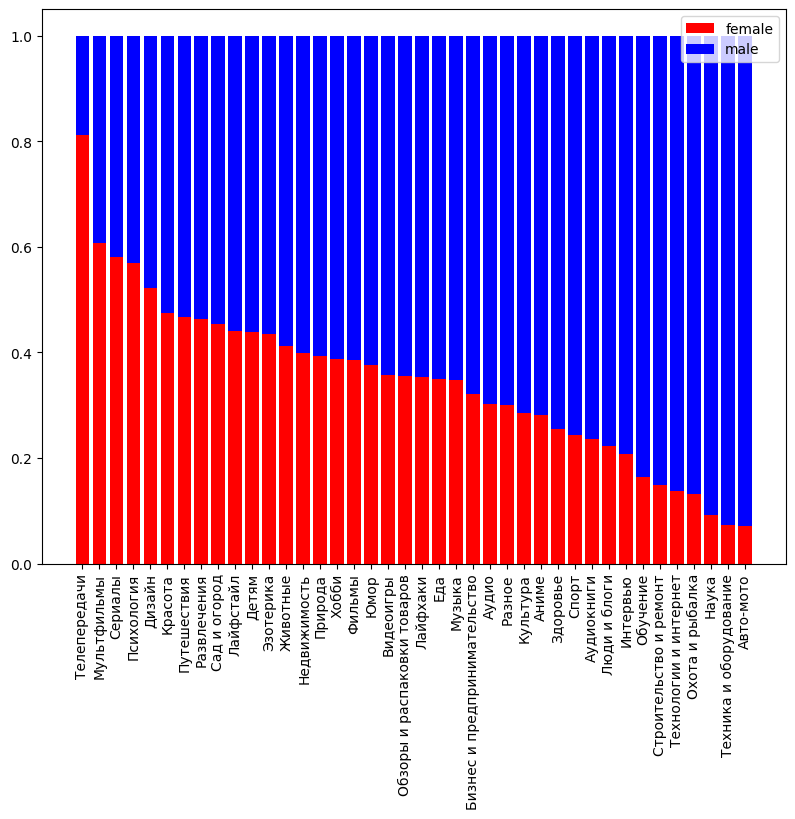

In [18]:
make_gender_bars_relative("category", merged)

Причем из просмотров телепередач 80% являются женскими.

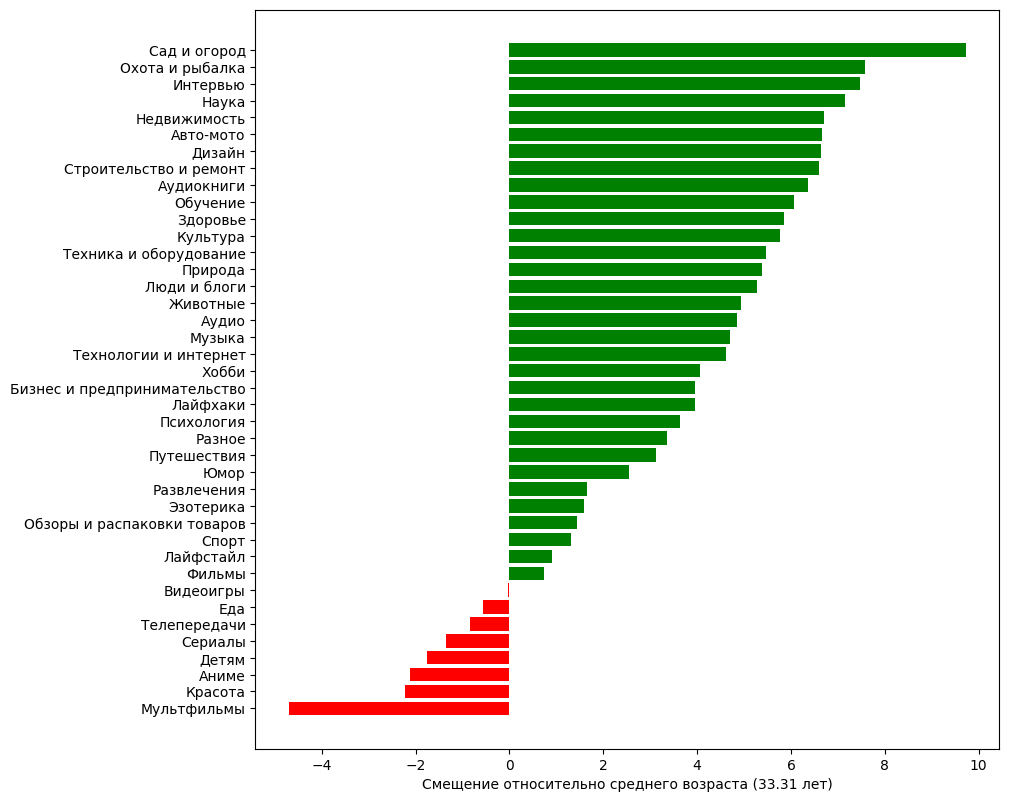

In [19]:
make_age_bias("category", merged)

Есть категории с большим смещением относительно среднего возраста. Категории выглядят логично. Аудитория мультфильмов моложе, аудитория контента про сад и огрод старше.

# Регионы

По регионам различия, ожидаемо, небольшие.

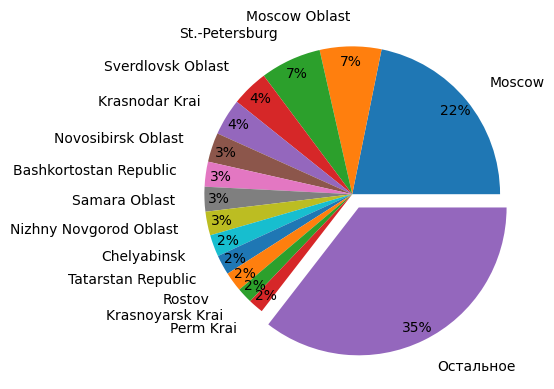

In [20]:
make_pie_chart("region", merged, 14)

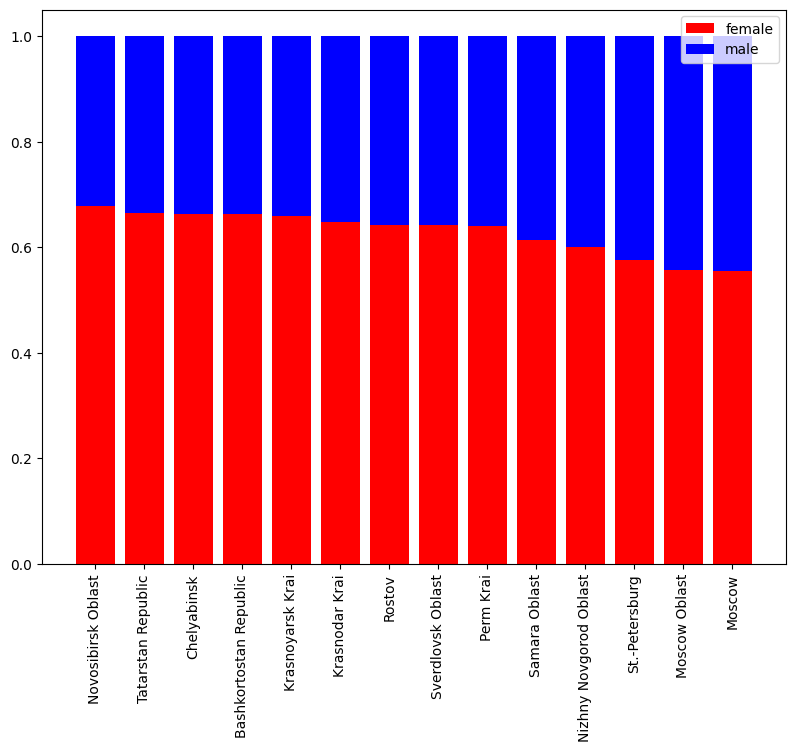

In [21]:
make_gender_bars_relative("region", merged, 14)

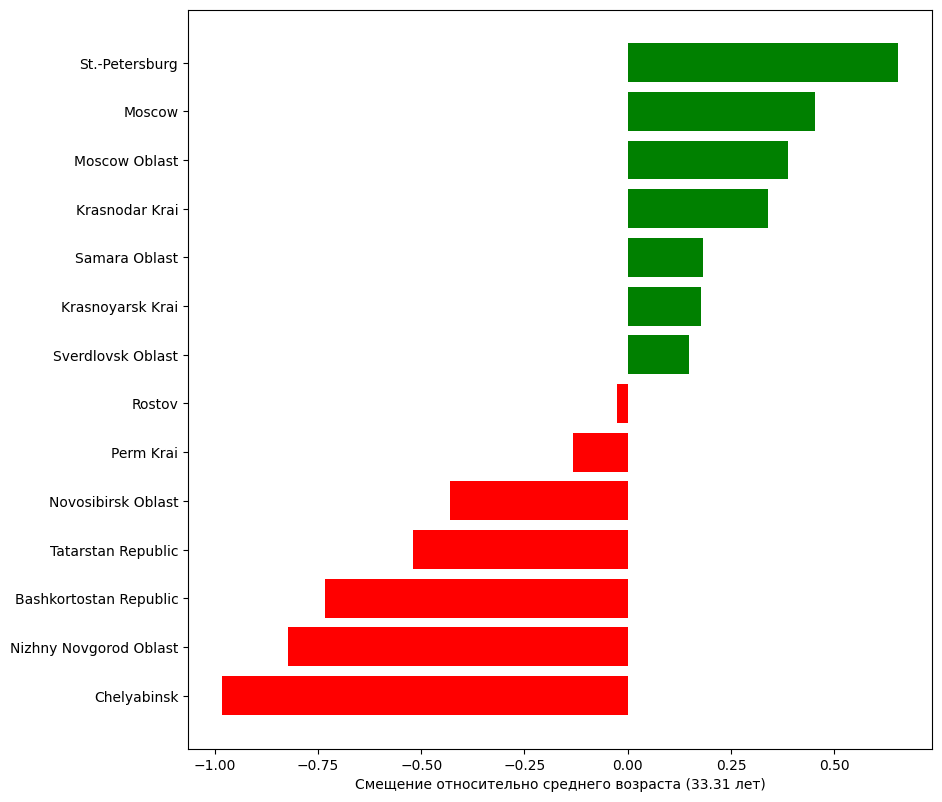

In [22]:
make_age_bias("region", merged, 14)

# Тип устройства

Tablet и smartphone похожи, desktop от них отличается.

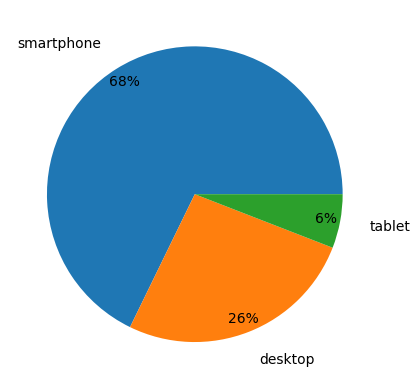

In [23]:
make_pie_chart("ua_device_type", merged)

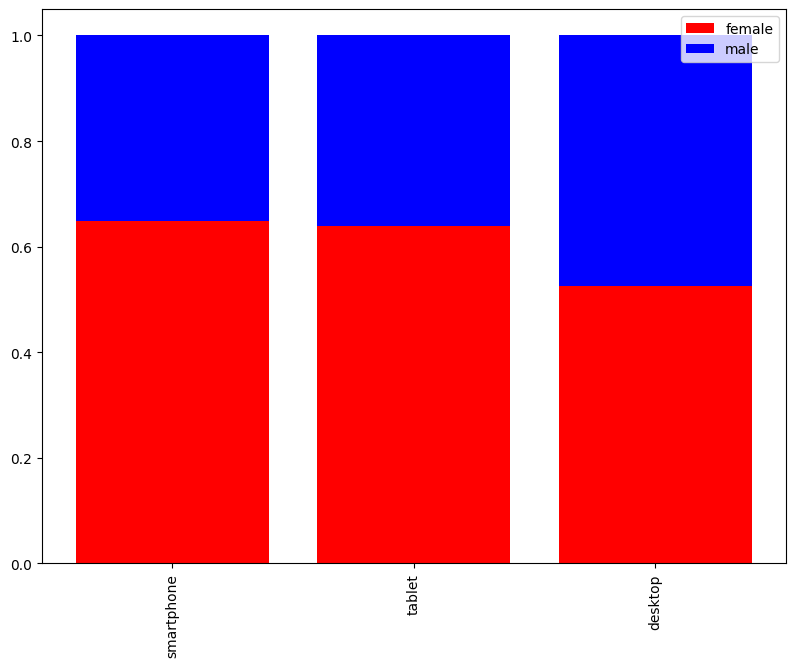

In [24]:
make_gender_bars_relative("ua_device_type", merged)

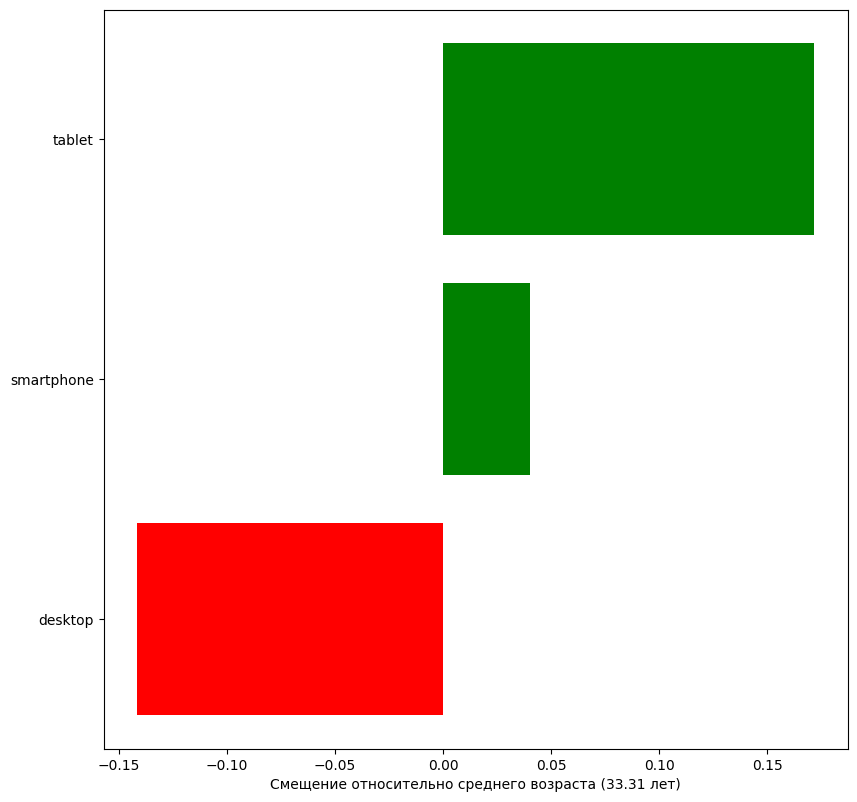

In [25]:
make_age_bias("ua_device_type", merged)

# Тип клиента

Есть третий тип клиента "av", который встречается всего 19 раз.

In [26]:
merged["ua_client_type"].value_counts()

ua_client_type
mobile app    1140259
browser        619338
av                 19
Name: count, dtype: int64

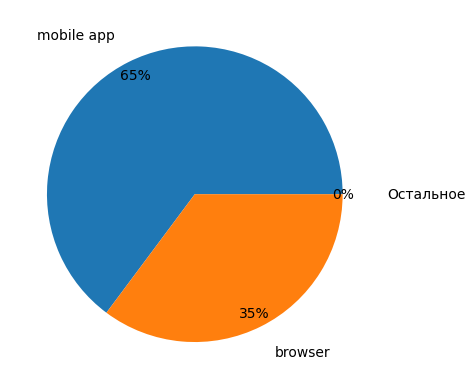

In [27]:
make_pie_chart("ua_client_type", merged, 2)

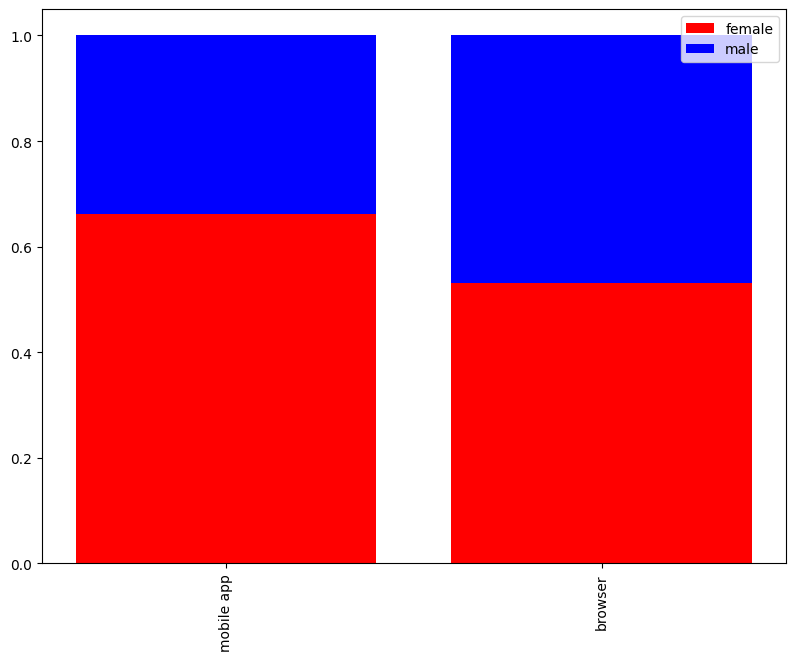

In [28]:
make_gender_bars_relative("ua_client_type", merged, 2)

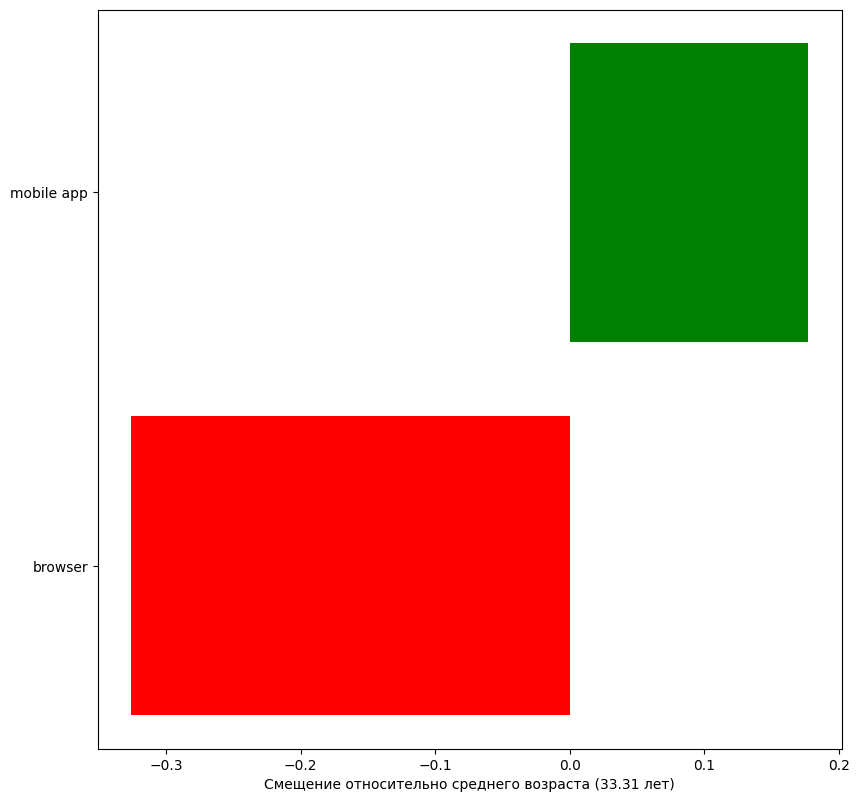

In [29]:
make_age_bias("ua_client_type", merged, 2)

# Операционная система

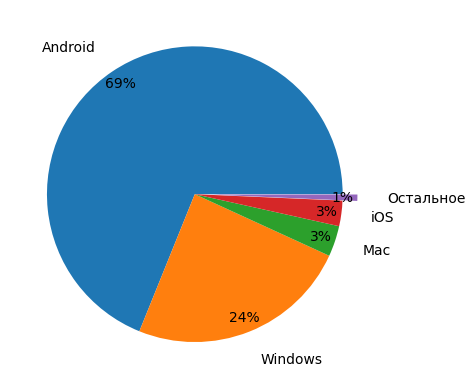

In [30]:
make_pie_chart("ua_os", merged, 4)

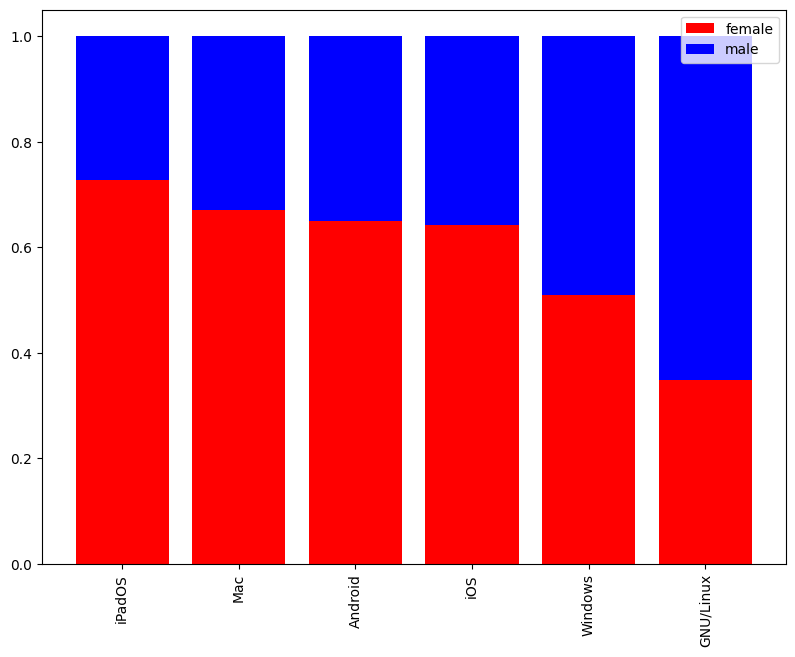

In [31]:
make_gender_bars_relative("ua_os", merged, 6)

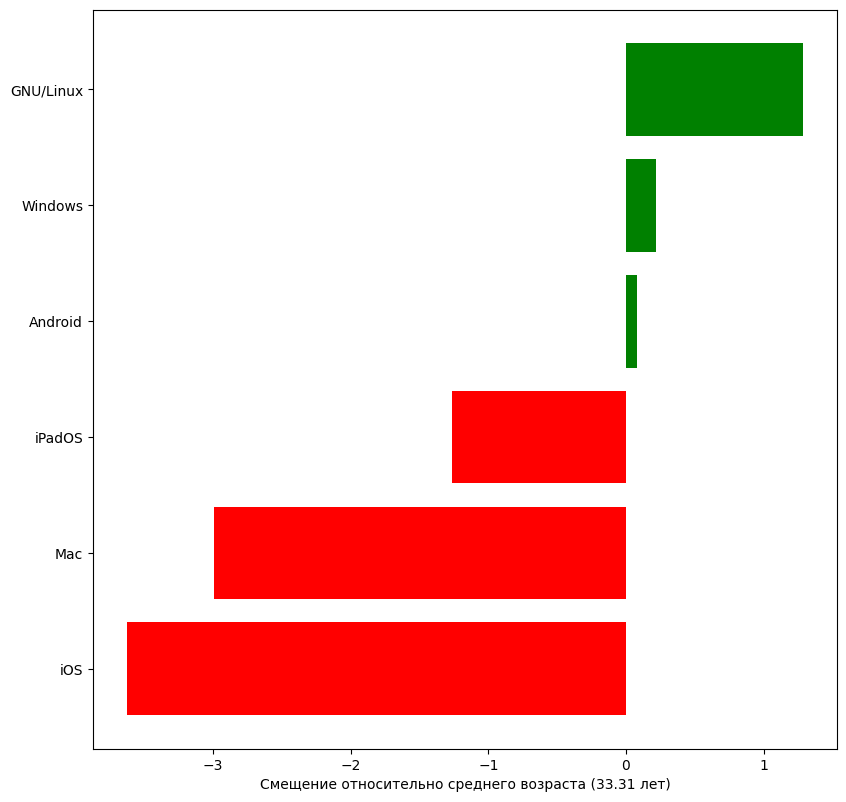

In [32]:
make_age_bias("ua_os", merged, 6)

# Имя клиента

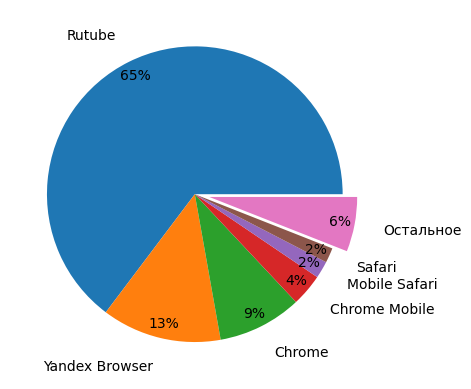

In [33]:
make_pie_chart("ua_client_name", merged, 6)

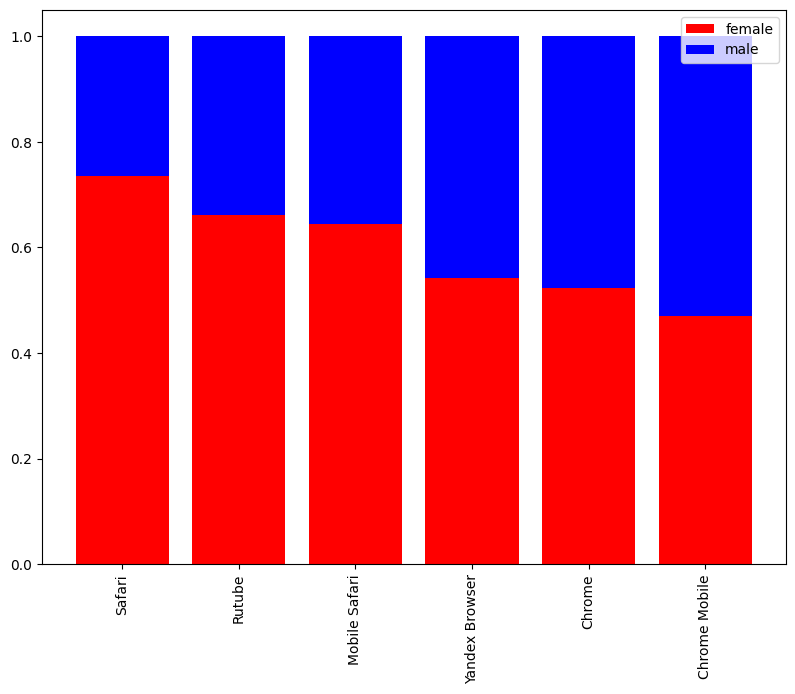

In [34]:
make_gender_bars_relative("ua_client_name", merged, 6)

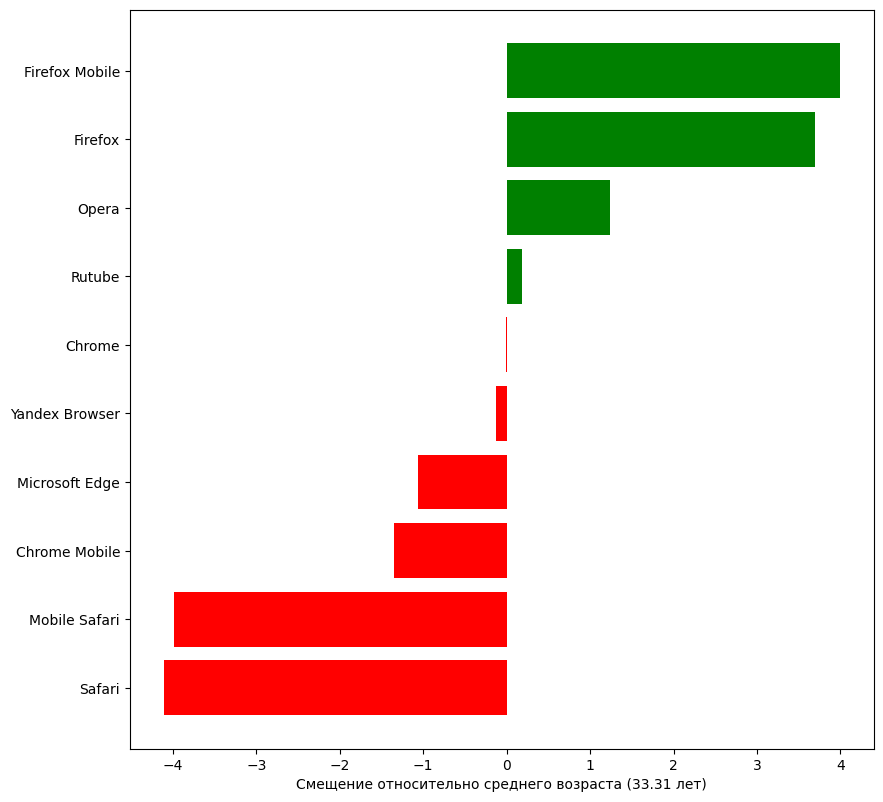

In [35]:
make_age_bias("ua_client_name", merged, 10)

# По часу дня

Сравнение пользователей по часу просмотра:

In [40]:
region_time_offsets = {
    'Adygeya Republic': 3,
    'Altai': 7,
    'Altay Kray': 7,
    'Amur Oblast': 9,
    'Arkhangelsk Oblast': 3,
    'Arkhangelskaya': 3,
    'Astrakhan': 4,
    'Astrakhan Oblast': 4,
    'Bashkortostan Republic': 5,
    'Belgorod Oblast': 3,
    'Bryansk Oblast': 3,
    'Buryatiya Republic': 8,
    'Chechnya': 3,
    'Chelyabinsk': 5,
    'Chukotka': 12,
    'Chuvashia': 3,
    'Crimea': 3,
    'Dagestan': 3,
    'Ingushetiya Republic': 3,
    'Irkutsk Oblast': 8,
    'Ivanovo': 3,
    'Ivanovo Oblast': 3,
    'Jaroslavl': 3,
    'Jewish Autonomous Oblast': 10,
    'Kabardino-Balkariya Republic': 3,
    'Kaliningrad': 2,
    'Kaliningrad Oblast': 2,
    'Kalmykiya Republic': 4,
    'Kaluga': 3,
    'Kaluga Oblast': 3,
    'Kamchatka': 12,
    'Karachayevo-Cherkesiya Republic': 3,
    'Karelia': 3,
    'Kemerovo Oblast': 7,
    'Khabarovsk': 10,
    'Khakasiya Republic': 7,
    'Khanty-Mansia': 5,
    'Kirov': 3,
    'Kirov Oblast': 3,
    'Komi': 3,
    'Kostroma Oblast': 3,
    'Krasnodar Krai': 3,
    'Krasnodarskiy': 3,
    'Krasnoyarsk Krai': 7,
    'Krasnoyarskiy': 7,
    'Kurgan Oblast': 5,
    'Kursk': 3,
    'Kursk Oblast': 3,
    'Kuzbass': 7,
    "Leningradskaya Oblast'": 3,
    'Lipetsk Oblast': 3,
    'Magadan Oblast': 11,
    'Mariy-El Republic': 3,
    'Mordoviya Republic': 3,
    'Moscow': 3,
    'Moscow Oblast': 3,
    'Murmansk': 3,
    'Nenets': 3,
    'Nizhny Novgorod Oblast': 3,
    'North Ossetia': 3,
    'North Ossetia–Alania': 3,
    'Novgorod Oblast': 3,
    'Novosibirsk Oblast': 7,
    'Omsk': 6,
    'Omsk Oblast': 6,
    'Orel Oblast': 3,
    'Orenburg Oblast': 5,
    'Oryol oblast': 3,
    'Penza': 3,
    'Penza Oblast': 3,
    'Perm': 5,
    'Perm Krai': 5,
    'Primorskiy (Maritime) Kray': 10,
    'Primorye': 10,
    'Pskov Oblast': 3,
    'Rostov': 3,
    'Ryazan Oblast': 3,
    'Sakha': 9,
    'Sakhalin Oblast': 11,
    'Samara Oblast': 4,
    'Saratov Oblast': 4,
    'Saratovskaya Oblast': 4,
    'Sebastopol City': 3,
    'Smolensk': 3,
    'Smolensk Oblast': 3,
    'Smolenskaya Oblast’': 3,
    'St.-Petersburg': 3,
    'Stavropol Krai': 3,
    'Stavropol Kray': 3,
    'Stavropol’ Kray': 3,
    'Sverdlovsk': 5,
    'Sverdlovsk Oblast': 5,
    'Tambov': 3,
    'Tambov Oblast': 3,
    'Tatarstan Republic': 3,
    'Tomsk Oblast': 7,
    'Transbaikal Territory': 9,
    'Tula': 3,
    'Tula Oblast': 3,
    'Tver Oblast': 3,
    'Tver’ Oblast': 3,
    'Tyumen Oblast': 5,
    'Tyumen’ Oblast': 5,
    'Tyva Republic': 7,
    'Udmurtiya Republic': 4,
    'Ulyanovsk': 4,
    'Vladimir': 3,
    'Vladimir Oblast': 3,
    'Volgograd Oblast': 4,
    'Vologda': 3,
    'Vologda Oblast': 3,
    'Voronezh Oblast': 3,
    'Voronezj': 3,
    'Yamalo-Nenets': 5,
    'Yaroslavl Oblast': 3,
    'Zabaykalskiy (Transbaikal) Kray': 9
}

def calculate_real_timestamp(df):
    # Получаем смещение для каждого региона
    df['region_offset'] = df['region'].map(region_time_offsets).fillna(3)  # По умолчанию UTC+3 (Москва)
    
    # Преобразуем event_timestamp в формат datetime (если еще не сделано)
    df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
    
    # Вычисляем реальное время, добавляя разницу между UTC+3 и временем региона
    df['real_timestamp'] = df['event_timestamp'] + pd.to_timedelta(df['region_offset'] - 3, unit='h')
        
    df = df.drop('region_offset', axis=1)
    
    return df

In [50]:
merged_with_hour = merged.copy()
merged_with_hour = calculate_real_timestamp(merged_with_hour)
merged_with_hour["hour"] = merged_with_hour["real_timestamp"].dt.hour

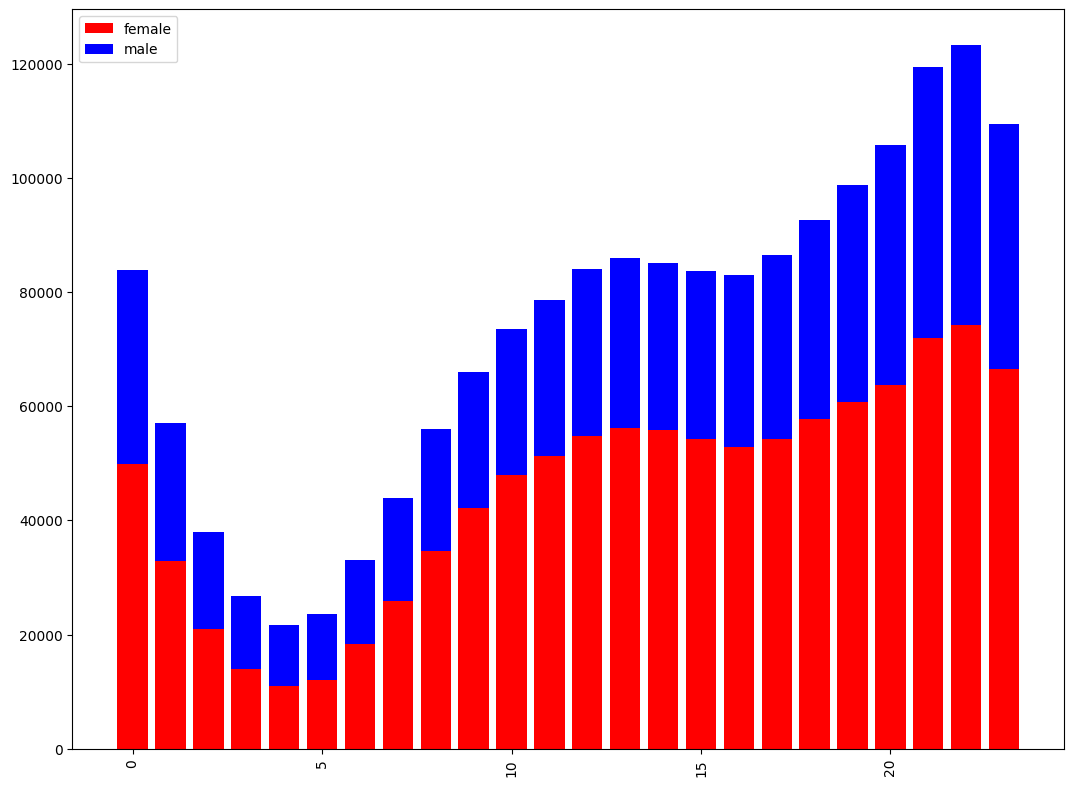

In [51]:
make_gender_bars("hour", merged_with_hour)

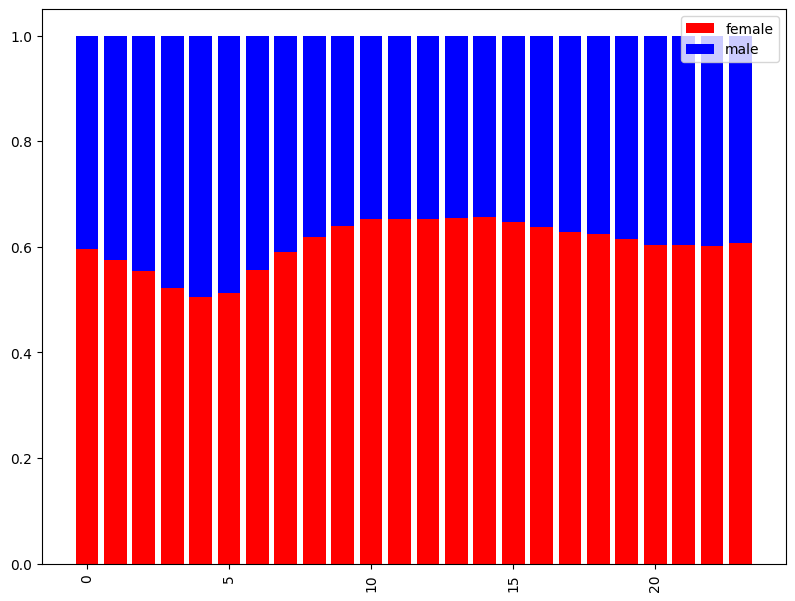

In [52]:
make_gender_bars_relative("hour", merged_with_hour)

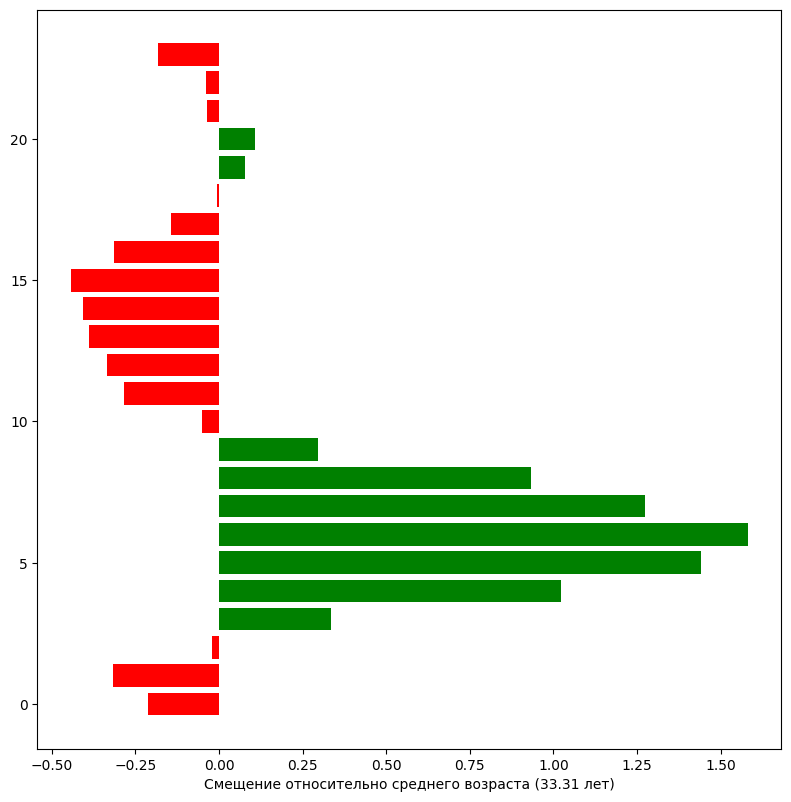

In [53]:
make_age_bias("hour", merged_with_hour)